In [4]:
# Import
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('/home/user/workdir/main/src/'))))

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

Memory growth enabled for GPUs


# Training (Nitrate)

In [5]:
emis_ctrl_2019_10 = pd.read_csv('/home/user/workdir/main/resources/ctrl/precursor_control_2019_4input_scaled_o3.csv')
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]
# -------------
base_path_2019 = '/home/user/workdir/main/datasets/concentration/2019'

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [6]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model'  # 모델 저장 경로

epochs = 500  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 32  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed)

# devices=["/GPU:1","/GPU:2","/GPU:3"]
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*5,
        cond_dim=[1],
        emb_dims=[128],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[128, 96],
        hidden_depth=4,
        in_filters=20,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
    )

# define callback
def scheduler(epoch, lr):
    if epoch <= 1000: return 1e-3
    else: return 5e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Epoch 1/500
INFO:tensorflow:Collective all_reduce tensors: 84 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 84 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 84 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 84 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


3/3 [==============================] - ETA: 0s - loss: 20.6891INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-01-28.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-01-28.91/assets


3/3 [==============================] - 42s 7s/step - loss: 20.6891 - val_loss: 28.9092 - lr: 0.0010
Epoch 2/500
3/3 [==============================] - ETA: 0s - loss: 7.6954INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-02-25.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-02-25.89/assets


3/3 [==============================] - 8s 4s/step - loss: 7.6954 - val_loss: 25.8922 - lr: 0.0010
Epoch 3/500
3/3 [==============================] - ETA: 0s - loss: 5.8228INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-03-20.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-03-20.35/assets


3/3 [==============================] - 11s 6s/step - loss: 5.8228 - val_loss: 20.3481 - lr: 0.0010
Epoch 4/500
3/3 [==============================] - ETA: 0s - loss: 5.1243INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-04-13.61/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-04-13.61/assets


3/3 [==============================] - 8s 4s/step - loss: 5.1243 - val_loss: 13.6068 - lr: 0.0010
Epoch 5/500
3/3 [==============================] - ETA: 0s - loss: 4.6511INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-05-9.97/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-05-9.97/assets


3/3 [==============================] - 11s 6s/step - loss: 4.6511 - val_loss: 9.9711 - lr: 0.0010
Epoch 6/500
3/3 [==============================] - ETA: 0s - loss: 4.2603INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-06-9.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-06-9.05/assets


3/3 [==============================] - 8s 4s/step - loss: 4.2603 - val_loss: 9.0472 - lr: 0.0010
Epoch 7/500
3/3 [==============================] - 1s 241ms/step - loss: 3.9098 - val_loss: 9.2128 - lr: 0.0010
Epoch 8/500
3/3 [==============================] - 0s 202ms/step - loss: 3.5921 - val_loss: 9.2292 - lr: 0.0010
Epoch 9/500
3/3 [==============================] - ETA: 0s - loss: 3.2605INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-09-8.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-09-8.89/assets


3/3 [==============================] - 8s 4s/step - loss: 3.2605 - val_loss: 8.8876 - lr: 0.0010
Epoch 10/500
3/3 [==============================] - ETA: 0s - loss: 2.8497INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-10-8.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-10-8.79/assets


3/3 [==============================] - 12s 6s/step - loss: 2.8497 - val_loss: 8.7886 - lr: 0.0010
Epoch 11/500
3/3 [==============================] - ETA: 0s - loss: 2.4449INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-11-7.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-11-7.40/assets


3/3 [==============================] - 8s 4s/step - loss: 2.4449 - val_loss: 7.4006 - lr: 0.0010
Epoch 12/500
3/3 [==============================] - 0s 217ms/step - loss: 2.1343 - val_loss: 8.5308 - lr: 0.0010
Epoch 13/500
3/3 [==============================] - ETA: 0s - loss: 1.8732INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-13-6.99/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-13-6.99/assets


3/3 [==============================] - 8s 4s/step - loss: 1.8732 - val_loss: 6.9862 - lr: 0.0010
Epoch 14/500
3/3 [==============================] - ETA: 0s - loss: 1.6435INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-14-6.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-14-6.48/assets


3/3 [==============================] - 12s 6s/step - loss: 1.6435 - val_loss: 6.4760 - lr: 0.0010
Epoch 15/500
3/3 [==============================] - 0s 205ms/step - loss: 1.4428 - val_loss: 6.6256 - lr: 0.0010
Epoch 16/500
3/3 [==============================] - ETA: 0s - loss: 1.2732INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-16-6.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-16-6.35/assets


3/3 [==============================] - 8s 4s/step - loss: 1.2732 - val_loss: 6.3506 - lr: 0.0010
Epoch 17/500
3/3 [==============================] - ETA: 0s - loss: 1.1254INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-17-6.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-17-6.23/assets


3/3 [==============================] - 8s 4s/step - loss: 1.1254 - val_loss: 6.2255 - lr: 0.0010
Epoch 18/500
3/3 [==============================] - 0s 208ms/step - loss: 0.9996 - val_loss: 6.2581 - lr: 0.0010
Epoch 19/500
3/3 [==============================] - 0s 218ms/step - loss: 0.8862 - val_loss: 6.4430 - lr: 0.0010
Epoch 20/500
3/3 [==============================] - 0s 195ms/step - loss: 0.7850 - val_loss: 6.5518 - lr: 0.0010
Epoch 21/500
3/3 [==============================] - 1s 231ms/step - loss: 0.7017 - val_loss: 6.5132 - lr: 0.0010
Epoch 22/500
3/3 [==============================] - ETA: 0s - loss: 0.6530INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-22-6.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-22-6.07/assets


3/3 [==============================] - 12s 6s/step - loss: 0.6530 - val_loss: 6.0737 - lr: 0.0010
Epoch 23/500
3/3 [==============================] - ETA: 0s - loss: 0.5632INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-23-5.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-23-5.89/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5632 - val_loss: 5.8890 - lr: 0.0010
Epoch 24/500
3/3 [==============================] - 0s 195ms/step - loss: 0.5025 - val_loss: 6.1526 - lr: 0.0010
Epoch 25/500
3/3 [==============================] - 0s 218ms/step - loss: 0.4533 - val_loss: 6.3012 - lr: 0.0010
Epoch 26/500
3/3 [==============================] - 0s 192ms/step - loss: 0.4742 - val_loss: 6.3554 - lr: 0.0010
Epoch 27/500
3/3 [==============================] - ETA: 0s - loss: 0.4188INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-27-5.36/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-27-5.36/assets


3/3 [==============================] - 12s 6s/step - loss: 0.4188 - val_loss: 5.3646 - lr: 0.0010
Epoch 28/500
3/3 [==============================] - 0s 211ms/step - loss: 0.3736 - val_loss: 5.5631 - lr: 0.0010
Epoch 29/500
3/3 [==============================] - 0s 196ms/step - loss: 0.3230 - val_loss: 5.6635 - lr: 0.0010
Epoch 30/500
3/3 [==============================] - 0s 197ms/step - loss: 0.2920 - val_loss: 5.9114 - lr: 0.0010
Epoch 31/500
3/3 [==============================] - 0s 217ms/step - loss: 0.2548 - val_loss: 6.1662 - lr: 0.0010
Epoch 32/500
3/3 [==============================] - 0s 213ms/step - loss: 0.2268 - val_loss: 6.2932 - lr: 0.0010
Epoch 33/500
3/3 [==============================] - 0s 201ms/step - loss: 0.2005 - val_loss: 6.4246 - lr: 0.0010
Epoch 34/500
3/3 [==============================] - 1s 250ms/step - loss: 0.1785 - val_loss: 6.5939 - lr: 0.0010
Epoch 35/500
3/3 [==============================] - 1s 235ms/step - loss: 0.1605 - val_loss: 6.7577 - lr: 0.001

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-54-5.21/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0212 - val_loss: 5.2145 - lr: 0.0010
Epoch 55/500
3/3 [==============================] - ETA: 0s - loss: 0.0192INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-55-5.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-55-5.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0192 - val_loss: 5.0258 - lr: 0.0010
Epoch 56/500
3/3 [==============================] - ETA: 0s - loss: 0.0174INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-56-4.90/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-56-4.90/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0174 - val_loss: 4.9005 - lr: 0.0010
Epoch 57/500
3/3 [==============================] - ETA: 0s - loss: 0.0168INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-57-4.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-57-4.68/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0168 - val_loss: 4.6819 - lr: 0.0010
Epoch 58/500
3/3 [==============================] - ETA: 0s - loss: 0.0163INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-58-4.51/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-58-4.51/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0163 - val_loss: 4.5061 - lr: 0.0010
Epoch 59/500
3/3 [==============================] - ETA: 0s - loss: 0.0156INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-59-4.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-59-4.35/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0156 - val_loss: 4.3543 - lr: 0.0010
Epoch 60/500
3/3 [==============================] - ETA: 0s - loss: 0.0138INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-60-4.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-60-4.27/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0138 - val_loss: 4.2745 - lr: 0.0010
Epoch 61/500
3/3 [==============================] - ETA: 0s - loss: 0.0137INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-61-4.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-61-4.08/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0137 - val_loss: 4.0789 - lr: 0.0010
Epoch 62/500
3/3 [==============================] - ETA: 0s - loss: 0.0130INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-62-3.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-62-3.88/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0130 - val_loss: 3.8847 - lr: 0.0010
Epoch 63/500
3/3 [==============================] - ETA: 0s - loss: 0.0149INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-63-3.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-63-3.76/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0149 - val_loss: 3.7593 - lr: 0.0010
Epoch 64/500
3/3 [==============================] - ETA: 0s - loss: 0.0172INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-64-3.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-64-3.63/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0172 - val_loss: 3.6267 - lr: 0.0010
Epoch 65/500
3/3 [==============================] - ETA: 0s - loss: 0.0138INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-65-3.51/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-65-3.51/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0138 - val_loss: 3.5145 - lr: 0.0010
Epoch 66/500
3/3 [==============================] - ETA: 0s - loss: 0.0131INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-66-3.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-66-3.39/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0131 - val_loss: 3.3865 - lr: 0.0010
Epoch 67/500
3/3 [==============================] - ETA: 0s - loss: 0.0139INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-67-3.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-67-3.30/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0139 - val_loss: 3.3000 - lr: 0.0010
Epoch 68/500
3/3 [==============================] - ETA: 0s - loss: 0.0162INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-68-3.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-68-3.15/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0162 - val_loss: 3.1518 - lr: 0.0010
Epoch 69/500
3/3 [==============================] - ETA: 0s - loss: 0.0142INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-69-3.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-69-3.10/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0142 - val_loss: 3.0964 - lr: 0.0010
Epoch 70/500
3/3 [==============================] - ETA: 0s - loss: 0.0129INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-70-2.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-70-2.89/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0129 - val_loss: 2.8851 - lr: 0.0010
Epoch 71/500
3/3 [==============================] - ETA: 0s - loss: 0.0147INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-71-2.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-71-2.81/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0147 - val_loss: 2.8082 - lr: 0.0010
Epoch 72/500
3/3 [==============================] - ETA: 0s - loss: 0.0139INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-72-2.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-72-2.73/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0139 - val_loss: 2.7342 - lr: 0.0010
Epoch 73/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0128 - val_loss: 2.7797 - lr: 0.0010
Epoch 74/500
3/3 [==============================] - ETA: 0s - loss: 0.0117INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-74-2.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-74-2.69/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0117 - val_loss: 2.6934 - lr: 0.0010
Epoch 75/500
3/3 [==============================] - ETA: 0s - loss: 0.0119INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-75-2.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-75-2.57/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0119 - val_loss: 2.5681 - lr: 0.0010
Epoch 76/500
3/3 [==============================] - 0s 204ms/step - loss: 0.0117 - val_loss: 2.5739 - lr: 0.0010
Epoch 77/500
3/3 [==============================] - ETA: 0s - loss: 0.0111INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-77-2.47/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-77-2.47/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0111 - val_loss: 2.4742 - lr: 0.0010
Epoch 78/500
3/3 [==============================] - ETA: 0s - loss: 0.0100INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-78-2.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-78-2.44/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0100 - val_loss: 2.4420 - lr: 0.0010
Epoch 79/500
3/3 [==============================] - ETA: 0s - loss: 0.0105INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-79-2.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-79-2.34/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0105 - val_loss: 2.3438 - lr: 0.0010
Epoch 80/500
3/3 [==============================] - ETA: 0s - loss: 0.0095INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-80-2.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-80-2.25/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0095 - val_loss: 2.2489 - lr: 0.0010
Epoch 81/500
3/3 [==============================] - ETA: 0s - loss: 0.0096INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-81-2.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-81-2.10/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0096 - val_loss: 2.0967 - lr: 0.0010
Epoch 82/500
3/3 [==============================] - ETA: 0s - loss: 0.0122INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-82-2.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-82-2.05/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0122 - val_loss: 2.0522 - lr: 0.0010
Epoch 83/500
3/3 [==============================] - ETA: 0s - loss: 0.0107INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-83-2.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-83-2.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0107 - val_loss: 2.0522 - lr: 0.0010
Epoch 84/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0108 - val_loss: 2.0799 - lr: 0.0010
Epoch 85/500
3/3 [==============================] - ETA: 0s - loss: 0.0109INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-85-1.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-85-1.98/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0109 - val_loss: 1.9821 - lr: 0.0010
Epoch 86/500
3/3 [==============================] - ETA: 0s - loss: 0.0105INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-86-1.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-86-1.92/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0105 - val_loss: 1.9218 - lr: 0.0010
Epoch 87/500
3/3 [==============================] - ETA: 0s - loss: 0.0092INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-87-1.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-87-1.88/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0092 - val_loss: 1.8810 - lr: 0.0010
Epoch 88/500
3/3 [==============================] - ETA: 0s - loss: 0.0090INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-88-1.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-88-1.81/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0090 - val_loss: 1.8111 - lr: 0.0010
Epoch 89/500
3/3 [==============================] - ETA: 0s - loss: 0.0091INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-89-1.75/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-89-1.75/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0091 - val_loss: 1.7516 - lr: 0.0010
Epoch 90/500
3/3 [==============================] - ETA: 0s - loss: 0.0086INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-90-1.72/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-90-1.72/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0086 - val_loss: 1.7211 - lr: 0.0010
Epoch 91/500
3/3 [==============================] - ETA: 0s - loss: 0.0082INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-91-1.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-91-1.62/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0082 - val_loss: 1.6240 - lr: 0.0010
Epoch 92/500
3/3 [==============================] - ETA: 0s - loss: 0.0089INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-92-1.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-92-1.59/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0089 - val_loss: 1.5903 - lr: 0.0010
Epoch 93/500
3/3 [==============================] - ETA: 0s - loss: 0.0083INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-93-1.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-93-1.57/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0083 - val_loss: 1.5680 - lr: 0.0010
Epoch 94/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0083 - val_loss: 1.6144 - lr: 0.0010
Epoch 95/500
3/3 [==============================] - ETA: 0s - loss: 0.0105INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-95-1.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-95-1.54/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0105 - val_loss: 1.5432 - lr: 0.0010
Epoch 96/500
3/3 [==============================] - ETA: 0s - loss: 0.0100INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-96-1.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-96-1.54/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0100 - val_loss: 1.5410 - lr: 0.0010
Epoch 97/500
3/3 [==============================] - ETA: 0s - loss: 0.0110INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-97-1.45/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-97-1.45/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0110 - val_loss: 1.4541 - lr: 0.0010
Epoch 98/500
3/3 [==============================] - ETA: 0s - loss: 0.0084INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-98-1.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-98-1.42/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0084 - val_loss: 1.4166 - lr: 0.0010
Epoch 99/500
3/3 [==============================] - ETA: 0s - loss: 0.0086INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-99-1.37/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-99-1.37/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0086 - val_loss: 1.3719 - lr: 0.0010
Epoch 100/500
3/3 [==============================] - ETA: 0s - loss: 0.0085INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-100-1.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-100-1.34/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0085 - val_loss: 1.3399 - lr: 0.0010
Epoch 101/500
3/3 [==============================] - ETA: 0s - loss: 0.0087INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-101-1.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-101-1.31/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0087 - val_loss: 1.3101 - lr: 0.0010
Epoch 102/500
3/3 [==============================] - ETA: 0s - loss: 0.0089INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-102-1.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-102-1.26/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0089 - val_loss: 1.2603 - lr: 0.0010
Epoch 103/500
3/3 [==============================] - ETA: 0s - loss: 0.0078INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-103-1.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-103-1.22/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0078 - val_loss: 1.2228 - lr: 0.0010
Epoch 104/500
3/3 [==============================] - ETA: 0s - loss: 0.0084INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-104-1.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-104-1.17/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0084 - val_loss: 1.1715 - lr: 0.0010
Epoch 105/500
3/3 [==============================] - ETA: 0s - loss: 0.0072INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-105-1.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-105-1.13/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0072 - val_loss: 1.1343 - lr: 0.0010
Epoch 106/500
3/3 [==============================] - ETA: 0s - loss: 0.0069INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-106-1.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-106-1.09/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0069 - val_loss: 1.0886 - lr: 0.0010
Epoch 107/500
3/3 [==============================] - ETA: 0s - loss: 0.0074INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-107-1.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-107-1.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0074 - val_loss: 1.0478 - lr: 0.0010
Epoch 108/500
3/3 [==============================] - ETA: 0s - loss: 0.0065INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-108-1.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-108-1.01/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0065 - val_loss: 1.0088 - lr: 0.0010
Epoch 109/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0068 - val_loss: 1.0145 - lr: 0.0010
Epoch 110/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0071 - val_loss: 1.0133 - lr: 0.0010
Epoch 111/500
3/3 [==============================] - ETA: 0s - loss: 0.0097INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-111-0.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-111-0.94/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0097 - val_loss: 0.9431 - lr: 0.0010
Epoch 112/500
3/3 [==============================] - ETA: 0s - loss: 0.0083INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-112-0.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-112-0.94/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0083 - val_loss: 0.9396 - lr: 0.0010
Epoch 113/500
3/3 [==============================] - ETA: 0s - loss: 0.0065INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-113-0.90/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-113-0.90/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0065 - val_loss: 0.8994 - lr: 0.0010
Epoch 114/500
3/3 [==============================] - ETA: 0s - loss: 0.0064INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-114-0.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-114-0.87/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0064 - val_loss: 0.8708 - lr: 0.0010
Epoch 115/500
3/3 [==============================] - ETA: 0s - loss: 0.0062INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-115-0.85/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-115-0.85/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0062 - val_loss: 0.8453 - lr: 0.0010
Epoch 116/500
3/3 [==============================] - ETA: 0s - loss: 0.0055INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-116-0.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-116-0.79/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0055 - val_loss: 0.7908 - lr: 0.0010
Epoch 117/500
3/3 [==============================] - ETA: 0s - loss: 0.0073INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-117-0.75/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-117-0.75/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0073 - val_loss: 0.7497 - lr: 0.0010
Epoch 118/500
3/3 [==============================] - ETA: 0s - loss: 0.0065INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-118-0.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-118-0.73/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0065 - val_loss: 0.7332 - lr: 0.0010
Epoch 119/500
3/3 [==============================] - ETA: 0s - loss: 0.0064INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-119-0.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-119-0.71/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0064 - val_loss: 0.7075 - lr: 0.0010
Epoch 120/500
3/3 [==============================] - ETA: 0s - loss: 0.0069INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-120-0.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-120-0.69/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0069 - val_loss: 0.6875 - lr: 0.0010
Epoch 121/500
3/3 [==============================] - ETA: 0s - loss: 0.0080INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-121-0.65/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-121-0.65/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0080 - val_loss: 0.6460 - lr: 0.0010
Epoch 122/500
3/3 [==============================] - ETA: 0s - loss: 0.0085INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-122-0.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-122-0.63/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0085 - val_loss: 0.6286 - lr: 0.0010
Epoch 123/500
3/3 [==============================] - ETA: 0s - loss: 0.0079INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-123-0.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-123-0.62/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0079 - val_loss: 0.6157 - lr: 0.0010
Epoch 124/500
3/3 [==============================] - ETA: 0s - loss: 0.0070INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-124-0.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-124-0.59/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0070 - val_loss: 0.5884 - lr: 0.0010
Epoch 125/500
3/3 [==============================] - ETA: 0s - loss: 0.0060INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-125-0.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-125-0.57/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0060 - val_loss: 0.5663 - lr: 0.0010
Epoch 126/500
3/3 [==============================] - ETA: 0s - loss: 0.0073INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-126-0.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-126-0.53/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0073 - val_loss: 0.5253 - lr: 0.0010
Epoch 127/500
3/3 [==============================] - ETA: 0s - loss: 0.0083INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-127-0.47/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-127-0.47/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0083 - val_loss: 0.4666 - lr: 0.0010
Epoch 128/500
3/3 [==============================] - ETA: 0s - loss: 0.0098INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-128-0.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-128-0.42/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0098 - val_loss: 0.4163 - lr: 0.0010
Epoch 129/500
3/3 [==============================] - ETA: 0s - loss: 0.0085INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-129-0.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-129-0.41/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0085 - val_loss: 0.4109 - lr: 0.0010
Epoch 130/500
3/3 [==============================] - ETA: 0s - loss: 0.0076INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-130-0.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-130-0.41/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0076 - val_loss: 0.4094 - lr: 0.0010
Epoch 131/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0090 - val_loss: 0.4313 - lr: 0.0010
Epoch 132/500
3/3 [==============================] - ETA: 0s - loss: 0.0070INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-132-0.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-132-0.38/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0070 - val_loss: 0.3837 - lr: 0.0010
Epoch 133/500
3/3 [==============================] - ETA: 0s - loss: 0.0061INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-133-0.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-133-0.35/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0061 - val_loss: 0.3514 - lr: 0.0010
Epoch 134/500
3/3 [==============================] - 0s 195ms/step - loss: 0.0066 - val_loss: 0.3604 - lr: 0.0010
Epoch 135/500
3/3 [==============================] - ETA: 0s - loss: 0.0078INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-135-0.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-135-0.35/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0078 - val_loss: 0.3513 - lr: 0.0010
Epoch 136/500
3/3 [==============================] - ETA: 0s - loss: 0.0063INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-136-0.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-136-0.31/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0063 - val_loss: 0.3133 - lr: 0.0010
Epoch 137/500
3/3 [==============================] - ETA: 0s - loss: 0.0068INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-137-0.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-137-0.29/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0068 - val_loss: 0.2896 - lr: 0.0010
Epoch 138/500
3/3 [==============================] - ETA: 0s - loss: 0.0074INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-138-0.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-138-0.27/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0074 - val_loss: 0.2748 - lr: 0.0010
Epoch 139/500
3/3 [==============================] - ETA: 0s - loss: 0.0068INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-139-0.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-139-0.26/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0068 - val_loss: 0.2611 - lr: 0.0010
Epoch 140/500
3/3 [==============================] - ETA: 0s - loss: 0.0057INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-140-0.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-140-0.24/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0057 - val_loss: 0.2412 - lr: 0.0010
Epoch 141/500
3/3 [==============================] - 1s 232ms/step - loss: 0.0051 - val_loss: 0.2546 - lr: 0.0010
Epoch 142/500
3/3 [==============================] - ETA: 0s - loss: 0.0065INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-142-0.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-142-0.24/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0065 - val_loss: 0.2370 - lr: 0.0010
Epoch 143/500
3/3 [==============================] - ETA: 0s - loss: 0.0057INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-143-0.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-143-0.20/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0057 - val_loss: 0.2035 - lr: 0.0010
Epoch 144/500
3/3 [==============================] - ETA: 0s - loss: 0.0062INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-144-0.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-144-0.19/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0062 - val_loss: 0.1892 - lr: 0.0010
Epoch 145/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0065 - val_loss: 0.2016 - lr: 0.0010
Epoch 146/500
3/3 [==============================] - ETA: 0s - loss: 0.0062INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-146-0.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-146-0.18/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0062 - val_loss: 0.1787 - lr: 0.0010
Epoch 147/500
3/3 [==============================] - ETA: 0s - loss: 0.0064INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-147-0.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-147-0.17/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0064 - val_loss: 0.1710 - lr: 0.0010
Epoch 148/500
3/3 [==============================] - 1s 229ms/step - loss: 0.0053 - val_loss: 0.1864 - lr: 0.0010
Epoch 149/500
3/3 [==============================] - ETA: 0s - loss: 0.0063INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-149-0.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-149-0.16/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0063 - val_loss: 0.1607 - lr: 0.0010
Epoch 150/500
3/3 [==============================] - ETA: 0s - loss: 0.0059INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-150-0.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-150-0.16/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0059 - val_loss: 0.1563 - lr: 0.0010
Epoch 151/500
3/3 [==============================] - ETA: 0s - loss: 0.0061INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-151-0.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-151-0.15/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0061 - val_loss: 0.1533 - lr: 0.0010
Epoch 152/500
3/3 [==============================] - ETA: 0s - loss: 0.0049INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-152-0.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-152-0.15/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0049 - val_loss: 0.1474 - lr: 0.0010
Epoch 153/500
3/3 [==============================] - ETA: 0s - loss: 0.0054INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-153-0.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-153-0.14/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0054 - val_loss: 0.1392 - lr: 0.0010
Epoch 154/500
3/3 [==============================] - ETA: 0s - loss: 0.0050INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-154-0.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-154-0.13/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0050 - val_loss: 0.1282 - lr: 0.0010
Epoch 155/500
3/3 [==============================] - ETA: 0s - loss: 0.0054INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-155-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-155-0.12/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0054 - val_loss: 0.1183 - lr: 0.0010
Epoch 156/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0058 - val_loss: 0.1205 - lr: 0.0010
Epoch 157/500
3/3 [==============================] - 0s 211ms/step - loss: 0.0051 - val_loss: 0.1404 - lr: 0.0010
Epoch 158/500
3/3 [==============================] - ETA: 0s - loss: 0.0063INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-158-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-158-0.12/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0063 - val_loss: 0.1158 - lr: 0.0010
Epoch 159/500
3/3 [==============================] - ETA: 0s - loss: 0.0062INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-159-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-159-0.11/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0062 - val_loss: 0.1084 - lr: 0.0010
Epoch 160/500
3/3 [==============================] - ETA: 0s - loss: 0.0061INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-160-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-160-0.10/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0061 - val_loss: 0.1041 - lr: 0.0010
Epoch 161/500
3/3 [==============================] - ETA: 0s - loss: 0.0063INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-161-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-161-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0063 - val_loss: 0.0936 - lr: 0.0010
Epoch 162/500
3/3 [==============================] - ETA: 0s - loss: 0.0058INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-162-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-162-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0058 - val_loss: 0.0852 - lr: 0.0010
Epoch 163/500
3/3 [==============================] - 0s 195ms/step - loss: 0.0060 - val_loss: 0.0856 - lr: 0.0010
Epoch 164/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0057 - val_loss: 0.0887 - lr: 0.0010
Epoch 165/500
3/3 [==============================] - ETA: 0s - loss: 0.0059INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-165-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-165-0.07/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0059 - val_loss: 0.0708 - lr: 0.0010
Epoch 166/500
3/3 [==============================] - ETA: 0s - loss: 0.0082INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-166-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-166-0.06/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0082 - val_loss: 0.0602 - lr: 0.0010
Epoch 167/500
3/3 [==============================] - 0s 218ms/step - loss: 0.0081 - val_loss: 0.0797 - lr: 0.0010
Epoch 168/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0079 - val_loss: 0.1033 - lr: 0.0010
Epoch 169/500
3/3 [==============================] - 1s 226ms/step - loss: 0.0081 - val_loss: 0.0608 - lr: 0.0010
Epoch 170/500
3/3 [==============================] - ETA: 0s - loss: 0.0064INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-170-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-170-0.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0064 - val_loss: 0.0553 - lr: 0.0010
Epoch 171/500
3/3 [==============================] - 0s 211ms/step - loss: 0.0064 - val_loss: 0.0641 - lr: 0.0010
Epoch 172/500
3/3 [==============================] - 0s 216ms/step - loss: 0.0055 - val_loss: 0.0584 - lr: 0.0010
Epoch 173/500
3/3 [==============================] - 0s 204ms/step - loss: 0.0045 - val_loss: 0.0556 - lr: 0.0010
Epoch 174/500
3/3 [==============================] - 1s 221ms/step - loss: 0.0043 - val_loss: 0.0588 - lr: 0.0010
Epoch 175/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0052 - val_loss: 0.0556 - lr: 0.0010
Epoch 176/500
3/3 [==============================] - ETA: 0s - loss: 0.0054INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-176-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-176-0.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0054 - val_loss: 0.0518 - lr: 0.0010
Epoch 177/500
3/3 [==============================] - ETA: 0s - loss: 0.0051INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-177-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-177-0.05/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0051 - val_loss: 0.0497 - lr: 0.0010
Epoch 178/500
3/3 [==============================] - ETA: 0s - loss: 0.0055INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-178-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-178-0.05/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0055 - val_loss: 0.0478 - lr: 0.0010
Epoch 179/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0042 - val_loss: 0.0522 - lr: 0.0010
Epoch 180/500
3/3 [==============================] - ETA: 0s - loss: 0.0048INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-180-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-180-0.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0048 - val_loss: 0.0466 - lr: 0.0010
Epoch 181/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0040 - val_loss: 0.0513 - lr: 0.0010
Epoch 182/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0037 - val_loss: 0.0498 - lr: 0.0010
Epoch 183/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0052 - val_loss: 0.0673 - lr: 0.0010
Epoch 184/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0064INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-184-0.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-184-0.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0067 - val_loss: 0.0453 - lr: 0.0010
Epoch 185/500
3/3 [==============================] - ETA: 0s - loss: 0.0058INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-185-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-185-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0058 - val_loss: 0.0360 - lr: 0.0010
Epoch 186/500
3/3 [==============================] - 1s 226ms/step - loss: 0.0071 - val_loss: 0.0412 - lr: 0.0010
Epoch 187/500
3/3 [==============================] - 1s 230ms/step - loss: 0.0065 - val_loss: 0.0405 - lr: 0.0010
Epoch 188/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0067 - val_loss: 0.0363 - lr: 0.0010
Epoch 189/500
3/3 [==============================] - ETA: 0s - loss: 0.0070INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-189-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-189-0.04/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0070 - val_loss: 0.0353 - lr: 0.0010
Epoch 190/500
3/3 [==============================] - 1s 234ms/step - loss: 0.0066 - val_loss: 0.0462 - lr: 0.0010
Epoch 191/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0066 - val_loss: 0.0558 - lr: 0.0010
Epoch 192/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0069 - val_loss: 0.0394 - lr: 0.0010
Epoch 193/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0062 - val_loss: 0.0385 - lr: 0.0010
Epoch 194/500
3/3 [==============================] - ETA: 0s - loss: 0.0066INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-194-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-194-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0066 - val_loss: 0.0326 - lr: 0.0010
Epoch 195/500
3/3 [==============================] - ETA: 0s - loss: 0.0054INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-195-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-195-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0054 - val_loss: 0.0277 - lr: 0.0010
Epoch 196/500
3/3 [==============================] - ETA: 0s - loss: 0.0056INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-196-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-196-0.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0056 - val_loss: 0.0265 - lr: 0.0010
Epoch 197/500
3/3 [==============================] - ETA: 0s - loss: 0.0069INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-197-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-197-0.03/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0069 - val_loss: 0.0257 - lr: 0.0010
Epoch 198/500
3/3 [==============================] - 0s 211ms/step - loss: 0.0075 - val_loss: 0.0379 - lr: 0.0010
Epoch 199/500
3/3 [==============================] - 1s 226ms/step - loss: 0.0073 - val_loss: 0.0348 - lr: 0.0010
Epoch 200/500
3/3 [==============================] - 0s 221ms/step - loss: 0.0056 - val_loss: 0.0481 - lr: 0.0010
Epoch 201/500
3/3 [==============================] - 1s 226ms/step - loss: 0.0069 - val_loss: 0.0425 - lr: 0.0010
Epoch 202/500
3/3 [==============================] - 1s 232ms/step - loss: 0.0063 - val_loss: 0.0300 - lr: 0.0010
Epoch 203/500
3/3 [==============================] - ETA: 0s - loss: 0.0058INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-203-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-203-0.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0058 - val_loss: 0.0240 - lr: 0.0010
Epoch 204/500
3/3 [==============================] - 1s 221ms/step - loss: 0.0058 - val_loss: 0.0243 - lr: 0.0010
Epoch 205/500
3/3 [==============================] - 0s 209ms/step - loss: 0.0050 - val_loss: 0.0282 - lr: 0.0010
Epoch 206/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0052 - val_loss: 0.0316 - lr: 0.0010
Epoch 207/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0045 - val_loss: 0.0329 - lr: 0.0010
Epoch 208/500
3/3 [==============================] - 1s 220ms/step - loss: 0.0038 - val_loss: 0.0361 - lr: 0.0010
Epoch 209/500
3/3 [==============================] - 0s 216ms/step - loss: 0.0051 - val_loss: 0.0275 - lr: 0.0010
Epoch 210/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0051 - val_loss: 0.0374 - lr: 0.0010
Epoch 211/500
3/3 [==============================] - 0s 190ms/step - loss: 0.0053 - val_loss: 0.0387 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-213-0.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0059 - val_loss: 0.0206 - lr: 0.0010
Epoch 214/500
3/3 [==============================] - 1s 244ms/step - loss: 0.0046 - val_loss: 0.0216 - lr: 0.0010
Epoch 215/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0061 - val_loss: 0.0259 - lr: 0.0010
Epoch 216/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0049 - val_loss: 0.0279 - lr: 0.0010
Epoch 217/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0050 - val_loss: 0.0249 - lr: 0.0010
Epoch 218/500
3/3 [==============================] - ETA: 0s - loss: 0.0050INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-218-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-218-0.02/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0050 - val_loss: 0.0206 - lr: 0.0010
Epoch 219/500
3/3 [==============================] - 0s 209ms/step - loss: 0.0048 - val_loss: 0.0233 - lr: 0.0010
Epoch 220/500
3/3 [==============================] - 1s 265ms/step - loss: 0.0041 - val_loss: 0.0242 - lr: 0.0010
Epoch 221/500
3/3 [==============================] - ETA: 0s - loss: 0.0041INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-221-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-221-0.02/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0041 - val_loss: 0.0198 - lr: 0.0010
Epoch 222/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0037 - val_loss: 0.0222 - lr: 0.0010
Epoch 223/500
3/3 [==============================] - ETA: 0s - loss: 0.0049INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-223-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-223-0.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0049 - val_loss: 0.0166 - lr: 0.0010
Epoch 224/500
3/3 [==============================] - ETA: 0s - loss: 0.0054INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-224-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-224-0.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0054 - val_loss: 0.0158 - lr: 0.0010
Epoch 225/500
3/3 [==============================] - ETA: 0s - loss: 0.0053INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-225-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-225-0.02/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0053 - val_loss: 0.0151 - lr: 0.0010
Epoch 226/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0047 - val_loss: 0.0194 - lr: 0.0010
Epoch 227/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0046 - val_loss: 0.0327 - lr: 0.0010
Epoch 228/500
3/3 [==============================] - ETA: 0s - loss: 0.0043INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-228-0.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-228-0.01/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0043 - val_loss: 0.0147 - lr: 0.0010
Epoch 229/500
3/3 [==============================] - 1s 248ms/step - loss: 0.0050 - val_loss: 0.0176 - lr: 0.0010
Epoch 230/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0044 - val_loss: 0.0150 - lr: 0.0010
Epoch 231/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0040 - val_loss: 0.0180 - lr: 0.0010
Epoch 232/500
3/3 [==============================] - ETA: 0s - loss: 0.0043INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-232-0.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-232-0.01/assets


3/3 [==============================] - 15s 7s/step - loss: 0.0043 - val_loss: 0.0114 - lr: 0.0010
Epoch 233/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0048 - val_loss: 0.0121 - lr: 0.0010
Epoch 234/500
3/3 [==============================] - ETA: 0s - loss: 0.0046INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-234-0.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-234-0.01/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0046 - val_loss: 0.0107 - lr: 0.0010
Epoch 235/500
3/3 [==============================] - 1s 225ms/step - loss: 0.0046 - val_loss: 0.0156 - lr: 0.0010
Epoch 236/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0038 - val_loss: 0.0164 - lr: 0.0010
Epoch 237/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0043 - val_loss: 0.0146 - lr: 0.0010
Epoch 238/500
3/3 [==============================] - 0s 191ms/step - loss: 0.0049 - val_loss: 0.0167 - lr: 0.0010
Epoch 239/500
3/3 [==============================] - 1s 232ms/step - loss: 0.0042 - val_loss: 0.0192 - lr: 0.0010
Epoch 240/500
3/3 [==============================] - 1s 244ms/step - loss: 0.0033 - val_loss: 0.0168 - lr: 0.0010
Epoch 241/500
3/3 [==============================] - ETA: 0s - loss: 0.0053INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-241-0.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-241-0.01/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0053 - val_loss: 0.0106 - lr: 0.0010
Epoch 242/500
3/3 [==============================] - ETA: 0s - loss: 0.0048INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-242-0.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-242-0.01/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0048 - val_loss: 0.0101 - lr: 0.0010
Epoch 243/500
3/3 [==============================] - 0s 215ms/step - loss: 0.0048 - val_loss: 0.0213 - lr: 0.0010
Epoch 244/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0042 - val_loss: 0.0171 - lr: 0.0010
Epoch 245/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0039 - val_loss: 0.0131 - lr: 0.0010
Epoch 246/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0037 - val_loss: 0.0114 - lr: 0.0010
Epoch 247/500
3/3 [==============================] - 0s 215ms/step - loss: 0.0049 - val_loss: 0.0126 - lr: 0.0010
Epoch 248/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0039 - val_loss: 0.0192 - lr: 0.0010
Epoch 249/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0042 - val_loss: 0.0195 - lr: 0.0010
Epoch 250/500
3/3 [==============================] - 0s 221ms/step - loss: 0.0043 - val_loss: 0.0125 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-253-0.01/assets


3/3 [==============================] - 15s 7s/step - loss: 0.0044 - val_loss: 0.0090 - lr: 0.0010
Epoch 254/500
3/3 [==============================] - 1s 228ms/step - loss: 0.0042 - val_loss: 0.0146 - lr: 0.0010
Epoch 255/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0042 - val_loss: 0.0187 - lr: 0.0010
Epoch 256/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0054 - val_loss: 0.0124 - lr: 0.0010
Epoch 257/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0063 - val_loss: 0.0219 - lr: 0.0010
Epoch 258/500
3/3 [==============================] - 1s 239ms/step - loss: 0.0051 - val_loss: 0.0113 - lr: 0.0010
Epoch 259/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0051 - val_loss: 0.0164 - lr: 0.0010
Epoch 260/500
3/3 [==============================] - 1s 253ms/step - loss: 0.0054 - val_loss: 0.0113 - lr: 0.0010
Epoch 261/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0049 - val_loss: 0.0103 - l

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-263-0.01/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0043 - val_loss: 0.0079 - lr: 0.0010
Epoch 264/500
3/3 [==============================] - ETA: 0s - loss: 0.0037INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-264-0.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-264-0.01/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0037 - val_loss: 0.0060 - lr: 0.0010
Epoch 265/500
3/3 [==============================] - 0s 216ms/step - loss: 0.0047 - val_loss: 0.0115 - lr: 0.0010
Epoch 266/500
3/3 [==============================] - 0s 188ms/step - loss: 0.0041 - val_loss: 0.0090 - lr: 0.0010
Epoch 267/500
3/3 [==============================] - 1s 237ms/step - loss: 0.0036 - val_loss: 0.0103 - lr: 0.0010
Epoch 268/500
3/3 [==============================] - 1s 238ms/step - loss: 0.0041 - val_loss: 0.0086 - lr: 0.0010
Epoch 269/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0033 - val_loss: 0.0098 - lr: 0.0010
Epoch 270/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0044 - val_loss: 0.0104 - lr: 0.0010
Epoch 271/500
3/3 [==============================] - 0s 218ms/step - loss: 0.0045 - val_loss: 0.0095 - lr: 0.0010
Epoch 272/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0035 - val_loss: 0.0083 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-322-0.01/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0046 - val_loss: 0.0058 - lr: 0.0010
Epoch 323/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0047 - val_loss: 0.0094 - lr: 0.0010
Epoch 324/500
3/3 [==============================] - 1s 223ms/step - loss: 0.0056 - val_loss: 0.0068 - lr: 0.0010
Epoch 325/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0039 - val_loss: 0.0082 - lr: 0.0010
Epoch 326/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0038 - val_loss: 0.0081 - lr: 0.0010
Epoch 327/500
3/3 [==============================] - 0s 221ms/step - loss: 0.0040 - val_loss: 0.0096 - lr: 0.0010
Epoch 328/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0040 - val_loss: 0.0078 - lr: 0.0010
Epoch 329/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0037 - val_loss: 0.0071 - lr: 0.0010
Epoch 330/500
3/3 [==============================] - 1s 232ms/step - loss: 0.0039 - val_loss: 0.0063 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-353-0.00/assets


3/3 [==============================] - 15s 7s/step - loss: 0.0029 - val_loss: 0.0048 - lr: 0.0010
Epoch 354/500
3/3 [==============================] - ETA: 0s - loss: 0.0026INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-354-0.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-354-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0026 - val_loss: 0.0045 - lr: 0.0010
Epoch 355/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0028 - val_loss: 0.0059 - lr: 0.0010
Epoch 356/500
3/3 [==============================] - 1s 229ms/step - loss: 0.0031 - val_loss: 0.0074 - lr: 0.0010
Epoch 357/500
3/3 [==============================] - 0s 191ms/step - loss: 0.0026 - val_loss: 0.0065 - lr: 0.0010
Epoch 358/500
3/3 [==============================] - 1s 238ms/step - loss: 0.0032 - val_loss: 0.0056 - lr: 0.0010
Epoch 359/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0035 - val_loss: 0.0071 - lr: 0.0010
Epoch 360/500
3/3 [==============================] - 1s 235ms/step - loss: 0.0040 - val_loss: 0.0080 - lr: 0.0010
Epoch 361/500
3/3 [==============================] - 0s 219ms/step - loss: 0.0039 - val_loss: 0.0059 - lr: 0.0010
Epoch 362/500
3/3 [==============================] - 1s 250ms/step - loss: 0.0037 - val_loss: 0.0094 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-383-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0030 - val_loss: 0.0042 - lr: 0.0010
Epoch 384/500
3/3 [==============================] - 1s 225ms/step - loss: 0.0030 - val_loss: 0.0042 - lr: 0.0010
Epoch 385/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0028 - val_loss: 0.0047 - lr: 0.0010
Epoch 386/500
3/3 [==============================] - 0s 209ms/step - loss: 0.0037 - val_loss: 0.0071 - lr: 0.0010
Epoch 387/500
3/3 [==============================] - 0s 191ms/step - loss: 0.0043 - val_loss: 0.0074 - lr: 0.0010
Epoch 388/500
3/3 [==============================] - 0s 204ms/step - loss: 0.0042 - val_loss: 0.0052 - lr: 0.0010
Epoch 389/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0025 - val_loss: 0.0064 - lr: 0.0010
Epoch 390/500
3/3 [==============================] - 0s 217ms/step - loss: 0.0033 - val_loss: 0.0057 - lr: 0.0010
Epoch 391/500
3/3 [==============================] - 1s 226ms/step - loss: 0.0030 - val_loss: 0.0057 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-413-0.00/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0041 - val_loss: 0.0041 - lr: 0.0010
Epoch 414/500
3/3 [==============================] - 0s 215ms/step - loss: 0.0040 - val_loss: 0.0056 - lr: 0.0010
Epoch 415/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0031 - val_loss: 0.0063 - lr: 0.0010
Epoch 416/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0036 - val_loss: 0.0065 - lr: 0.0010
Epoch 417/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0027 - val_loss: 0.0155 - lr: 0.0010
Epoch 418/500
3/3 [==============================] - 1s 244ms/step - loss: 0.0037 - val_loss: 0.0053 - lr: 0.0010
Epoch 419/500
3/3 [==============================] - 0s 204ms/step - loss: 0.0041 - val_loss: 0.0066 - lr: 0.0010
Epoch 420/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0039 - val_loss: 0.0072 - lr: 0.0010
Epoch 421/500
3/3 [==============================] - 0s 204ms/step - loss: 0.0040 - val_loss: 0.0057 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-431-0.00/assets


3/3 [==============================] - 15s 7s/step - loss: 0.0038 - val_loss: 0.0041 - lr: 0.0010
Epoch 432/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0028 - val_loss: 0.0063 - lr: 0.0010
Epoch 433/500
3/3 [==============================] - 1s 225ms/step - loss: 0.0038 - val_loss: 0.0080 - lr: 0.0010
Epoch 434/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0035 - val_loss: 0.0055 - lr: 0.0010
Epoch 435/500
3/3 [==============================] - 0s 216ms/step - loss: 0.0037 - val_loss: 0.0053 - lr: 0.0010
Epoch 436/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0027 - val_loss: 0.0052 - lr: 0.0010
Epoch 437/500
3/3 [==============================] - 0s 224ms/step - loss: 0.0042 - val_loss: 0.0106 - lr: 0.0010
Epoch 438/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0046 - val_loss: 0.0056 - lr: 0.0010
Epoch 439/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0035 - val_loss: 0.0051 - l

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model-483-0.00/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0029 - val_loss: 0.0036 - lr: 0.0010
Epoch 484/500
3/3 [==============================] - 1s 237ms/step - loss: 0.0030 - val_loss: 0.0042 - lr: 0.0010
Epoch 485/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0025 - val_loss: 0.0045 - lr: 0.0010
Epoch 486/500
3/3 [==============================] - 0s 209ms/step - loss: 0.0023 - val_loss: 0.0057 - lr: 0.0010
Epoch 487/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0026 - val_loss: 0.0037 - lr: 0.0010
Epoch 488/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0018 - val_loss: 0.0039 - lr: 0.0010
Epoch 489/500
3/3 [==============================] - 0s 191ms/step - loss: 0.0016 - val_loss: 0.0040 - lr: 0.0010
Epoch 490/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0023 - val_loss: 0.0094 - lr: 0.0010
Epoch 491/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0024 - val_loss: 0.0052 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model/assets


' '

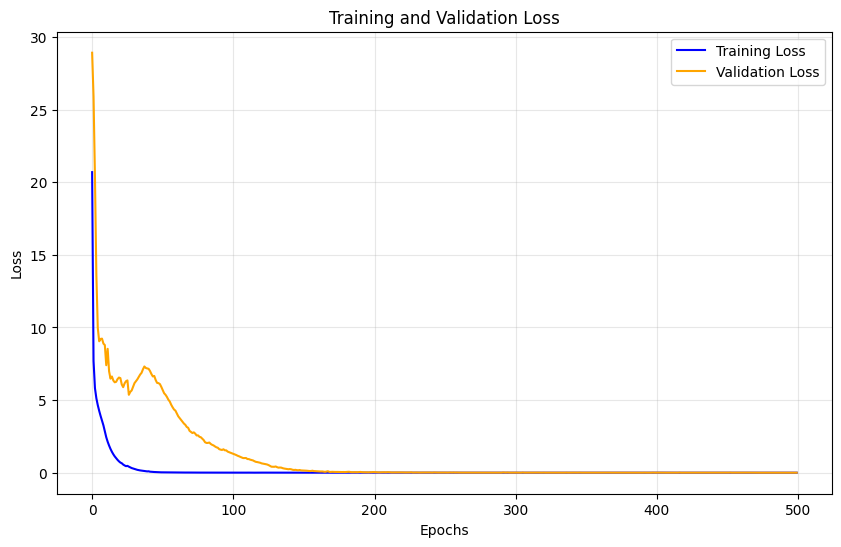

In [7]:
plot_loss(history)

# Prediction & Performance

In [8]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [9]:
def find_outliers_iqr(series, iqr_factor=1.5):
    """
    series: pd.Series
    iqr_factor: 1.5가 기본. (3.0으로 올리면 더 엄격히 outlier 판단)
    
    Returns
    -------
    pd.Series (dtype=bool), True이면 이상치
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - (iqr_factor * IQR)
    upper_bound = Q3 + (iqr_factor * IQR)
    
    outliers_mask = (series < lower_bound) | (series > upper_bound)
    return outliers_mask

In [10]:
'''
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 0  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/precursor_control_2019_4input_scaled_o3.csv')
emis_ctrl_2019_10['Boundary'] = 1.0

o3_cols = [col for col in emis_ctrl_2019_10.columns if "O3_ALL" in col]
df_o3 = emis_ctrl_2019_10[o3_cols].copy()

overall_outliers_mask = np.zeros(len(df_o3), dtype=bool)

for col in df_o3.columns:
    mask_outliers_col = find_outliers_iqr(df_o3[col], iqr_factor=1.5)
    # outlier로 판정된 행(True)는 OR(|=)로 합치기
    overall_outliers_mask |= mask_outliers_col

# 최종적으로 'O3 컬럼 중 하나라도 IQR 범위를 벗어난' 행
df_outliers_o3 = df_o3[~overall_outliers_mask]

print("O3 열 중 하나라도 outlier로 판정된 행 개수:", len(df_outliers_o3))
print(df_outliers_o3.head())

emis_ctrl_2019_10 = emis_ctrl_2019_10[~overall_outliers_mask]  # ~ : 반전
print("이상치 제외 후 df_inliers 크기:", emis_ctrl_2019_10.shape)

# =============

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

pred_emis_data, pred_boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2019/"
conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
conc_data = conc_data[~overall_outliers_mask]
print("이상치 제외에 맞춘 Label 크기:", conc_data.shape)

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 PM2.5 데이터 예측
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()
'''

'\ntest_split = 0.4  # 테스트 데이터 비율 (20%)\nrandom_seed = 0  # 랜덤 시드\nmodel = tf.keras.models.load_model(\'/home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model\')\n\npred_emis_data = []\npred_time_data = []\npred_boundary_data = []\n\n# Load Test Data\nemis_ctrl_2019_10 = pd.read_csv(\n    \'/home/user/workdir/main/resources/ctrl/precursor_control_2019_4input_scaled_o3.csv\')\nemis_ctrl_2019_10[\'Boundary\'] = 1.0\n\no3_cols = [col for col in emis_ctrl_2019_10.columns if "O3_ALL" in col]\ndf_o3 = emis_ctrl_2019_10[o3_cols].copy()\n\noverall_outliers_mask = np.zeros(len(df_o3), dtype=bool)\n\nfor col in df_o3.columns:\n    mask_outliers_col = find_outliers_iqr(df_o3[col], iqr_factor=1.5)\n    # outlier로 판정된 행(True)는 OR(|=)로 합치기\n    overall_outliers_mask |= mask_outliers_col\n\n# 최종적으로 \'O3 컬럼 중 하나라도 IQR 범위를 벗어난\' 행\ndf_outliers_o3 = df_o3[~overall_outliers_mask]\n\nprint("O3 열 중 하나라도 outlier로 판정된 행 개수:", len(df_outliers_o3))\nprint(df_outliers_o3.head())\n\nemis_ctrl_201

In [11]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/nitrate/scaled_o3/input5_modi/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/precursor_control_2019_4input_scaled_o3.csv')
emis_ctrl_2019_10['Boundary'] = 1.0

o3_cols = [col for col in emis_ctrl_2019_10.columns if "O3_ALL" in col]
overall_mask = np.zeros(len(emis_ctrl_2019_10), dtype=bool)
for col in emis_ctrl_2019_10.columns:
    if pd.api.types.is_numeric_dtype(emis_ctrl_2019_10[col]):
        mask_col = find_outliers_iqr(emis_ctrl_2019_10[col], iqr_factor=1.5)
        overall_mask |= mask_col  

# 최종 이상치 행
df_outliers = emis_ctrl_2019_10[overall_mask]
emis_ctrl_2019_10 = emis_ctrl_2019_10[~overall_mask]

print("전체 컬럼 중 하나라도 이상치인 행:", len(df_outliers))
print("이상치 제외 후 df_inliers 크기:", emis_ctrl_2019_10.shape)

# =============

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

pred_emis_data, pred_boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2019/"
conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
conc_data = conc_data[~overall_mask]
print("이상치 제외에 맞춘 Label 크기:", conc_data.shape)

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 PM2.5 데이터 예측
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

전체 컬럼 중 하나라도 이상치인 행: 5
이상치 제외 후 df_inliers 크기: (114, 86)
이상치 제외에 맞춘 Label 크기: (114, 82, 67, 1)
2/2 [==============================] - 2s 518ms/step


In [12]:
X_emis_test[38]

array([1.16985112, 0.747613  , 1.32067729, 1.31329615, 0.57291991,
       0.97306017, 1.25960598, 1.16209978, 1.09753432, 1.29811992,
       1.39233575, 1.3061789 , 1.01188527, 1.16780748, 0.98105541,
       0.67380752, 1.0192175 , 0.80748223, 0.83068957, 1.06017938,
       1.13736956, 1.14766074, 0.66637589, 0.89173405, 1.15441646,
       0.99566358, 1.02768476, 1.36935314, 0.91070449, 0.98671286,
       1.26000599, 1.3055484 , 0.76903728, 1.24920172, 1.2895833 ,
       0.80867354, 1.13825918, 1.24343596, 0.84208086, 1.18210355,
       0.9684886 , 0.9224894 , 0.67341221, 1.05877869, 1.24001114,
       1.11207926, 1.18192395, 0.62286315, 0.8998117 , 1.25626158,
       0.72866329, 0.75935929, 0.98375909, 1.01865691, 1.26384366,
       0.69240302, 0.83690998, 0.97268973, 0.88228046, 1.35325516,
       0.82597236, 0.89373434, 0.59418921, 0.83468512, 1.40404784,
       0.96150097, 1.022451  , 0.907084  , 1.12933832, 1.48442265,
       0.79582803, 1.09341486, 0.81805052, 0.74951955, 1.11460

In [13]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(46, 82, 67)
(46, 82, 67)
(46, 82, 67)
(46, 82, 67)


In [14]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=100, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    # y_err_std = np.std(y_norm_err, axis=1)  # (48,)
    return y_err_mean, y_err_std

In [15]:
def remove_outliers_by_relative_error(y_true, y_pred, max_rel_err=0.5):
    """
    상대 오차(max_rel_err)를 넘는 위치를 outlier로 간주하고 제외.
    원본 데이터 shape을 복원하기 위해 inliers(boolean index)도 반환.
    """
    # 1) 원본 shape과 flatten
    original_shape = y_true.shape
    y_true_flat = y_true.reshape(-1)
    y_pred_flat = y_pred.reshape(-1)
    
    # 2) 상대 오차 계산
    epsilon = 1e-8
    rel_err = np.abs(y_true_flat - y_pred_flat) / (y_true_flat + epsilon)
    
    # 3) inliers 찾기
    inliers = (rel_err <= max_rel_err)
    
    # 4) inlier만 골라 반환
    y_true_in = y_true_flat[inliers]
    y_pred_in = y_pred_flat[inliers]
    
    return y_true_in, y_pred_in, inliers, original_shape

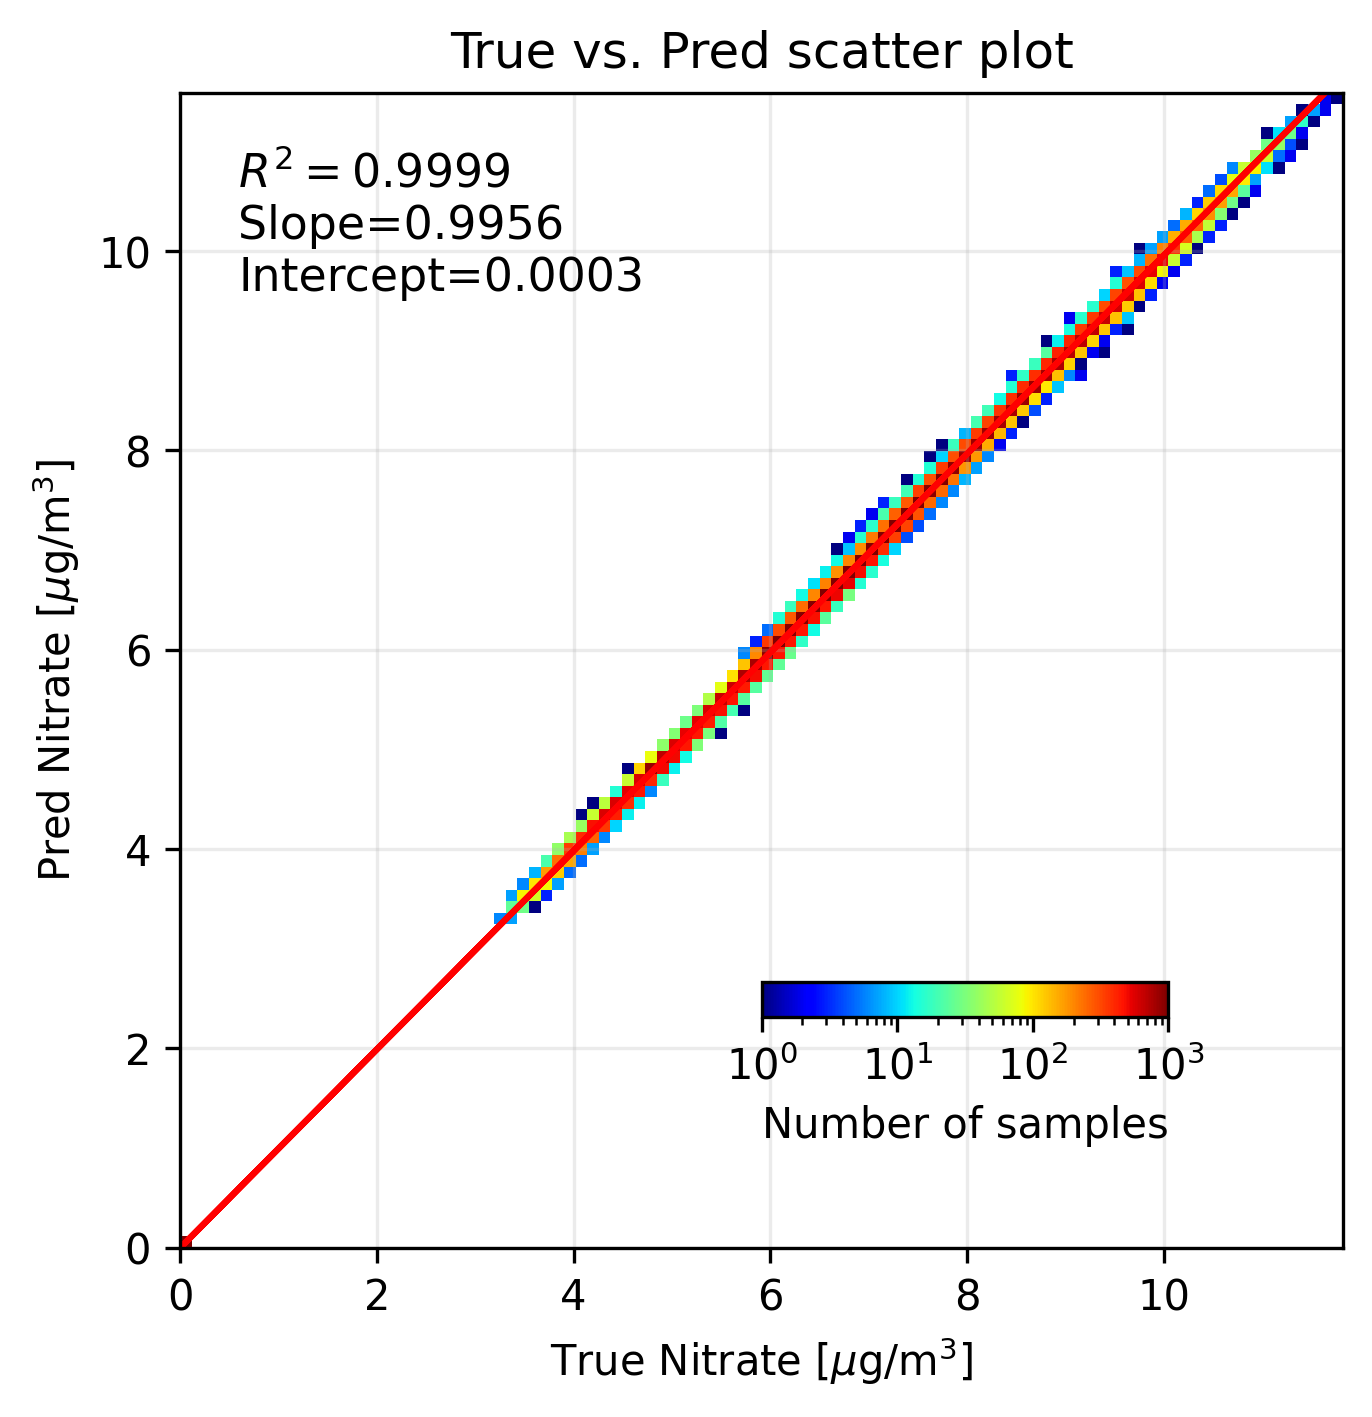

In [29]:
y_true_in, y_pred_in, inliers, original_shape = remove_outliers_by_relative_error(
    true_conc_map_w_lines, pred_conc_map_w_lines,
    max_rel_err=1
)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, true_conc_map_w_lines.reshape(-1), pred_conc_map_w_lines.reshape(-1))
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

In [17]:
y_pred_restored = np.full(np.prod(original_shape), np.nan, dtype=np.float32)
y_pred_restored[inliers] = y_pred_in
y_pred_restored = y_pred_restored.reshape(original_shape)
# y_pred_restored = y_pred_restored[0]

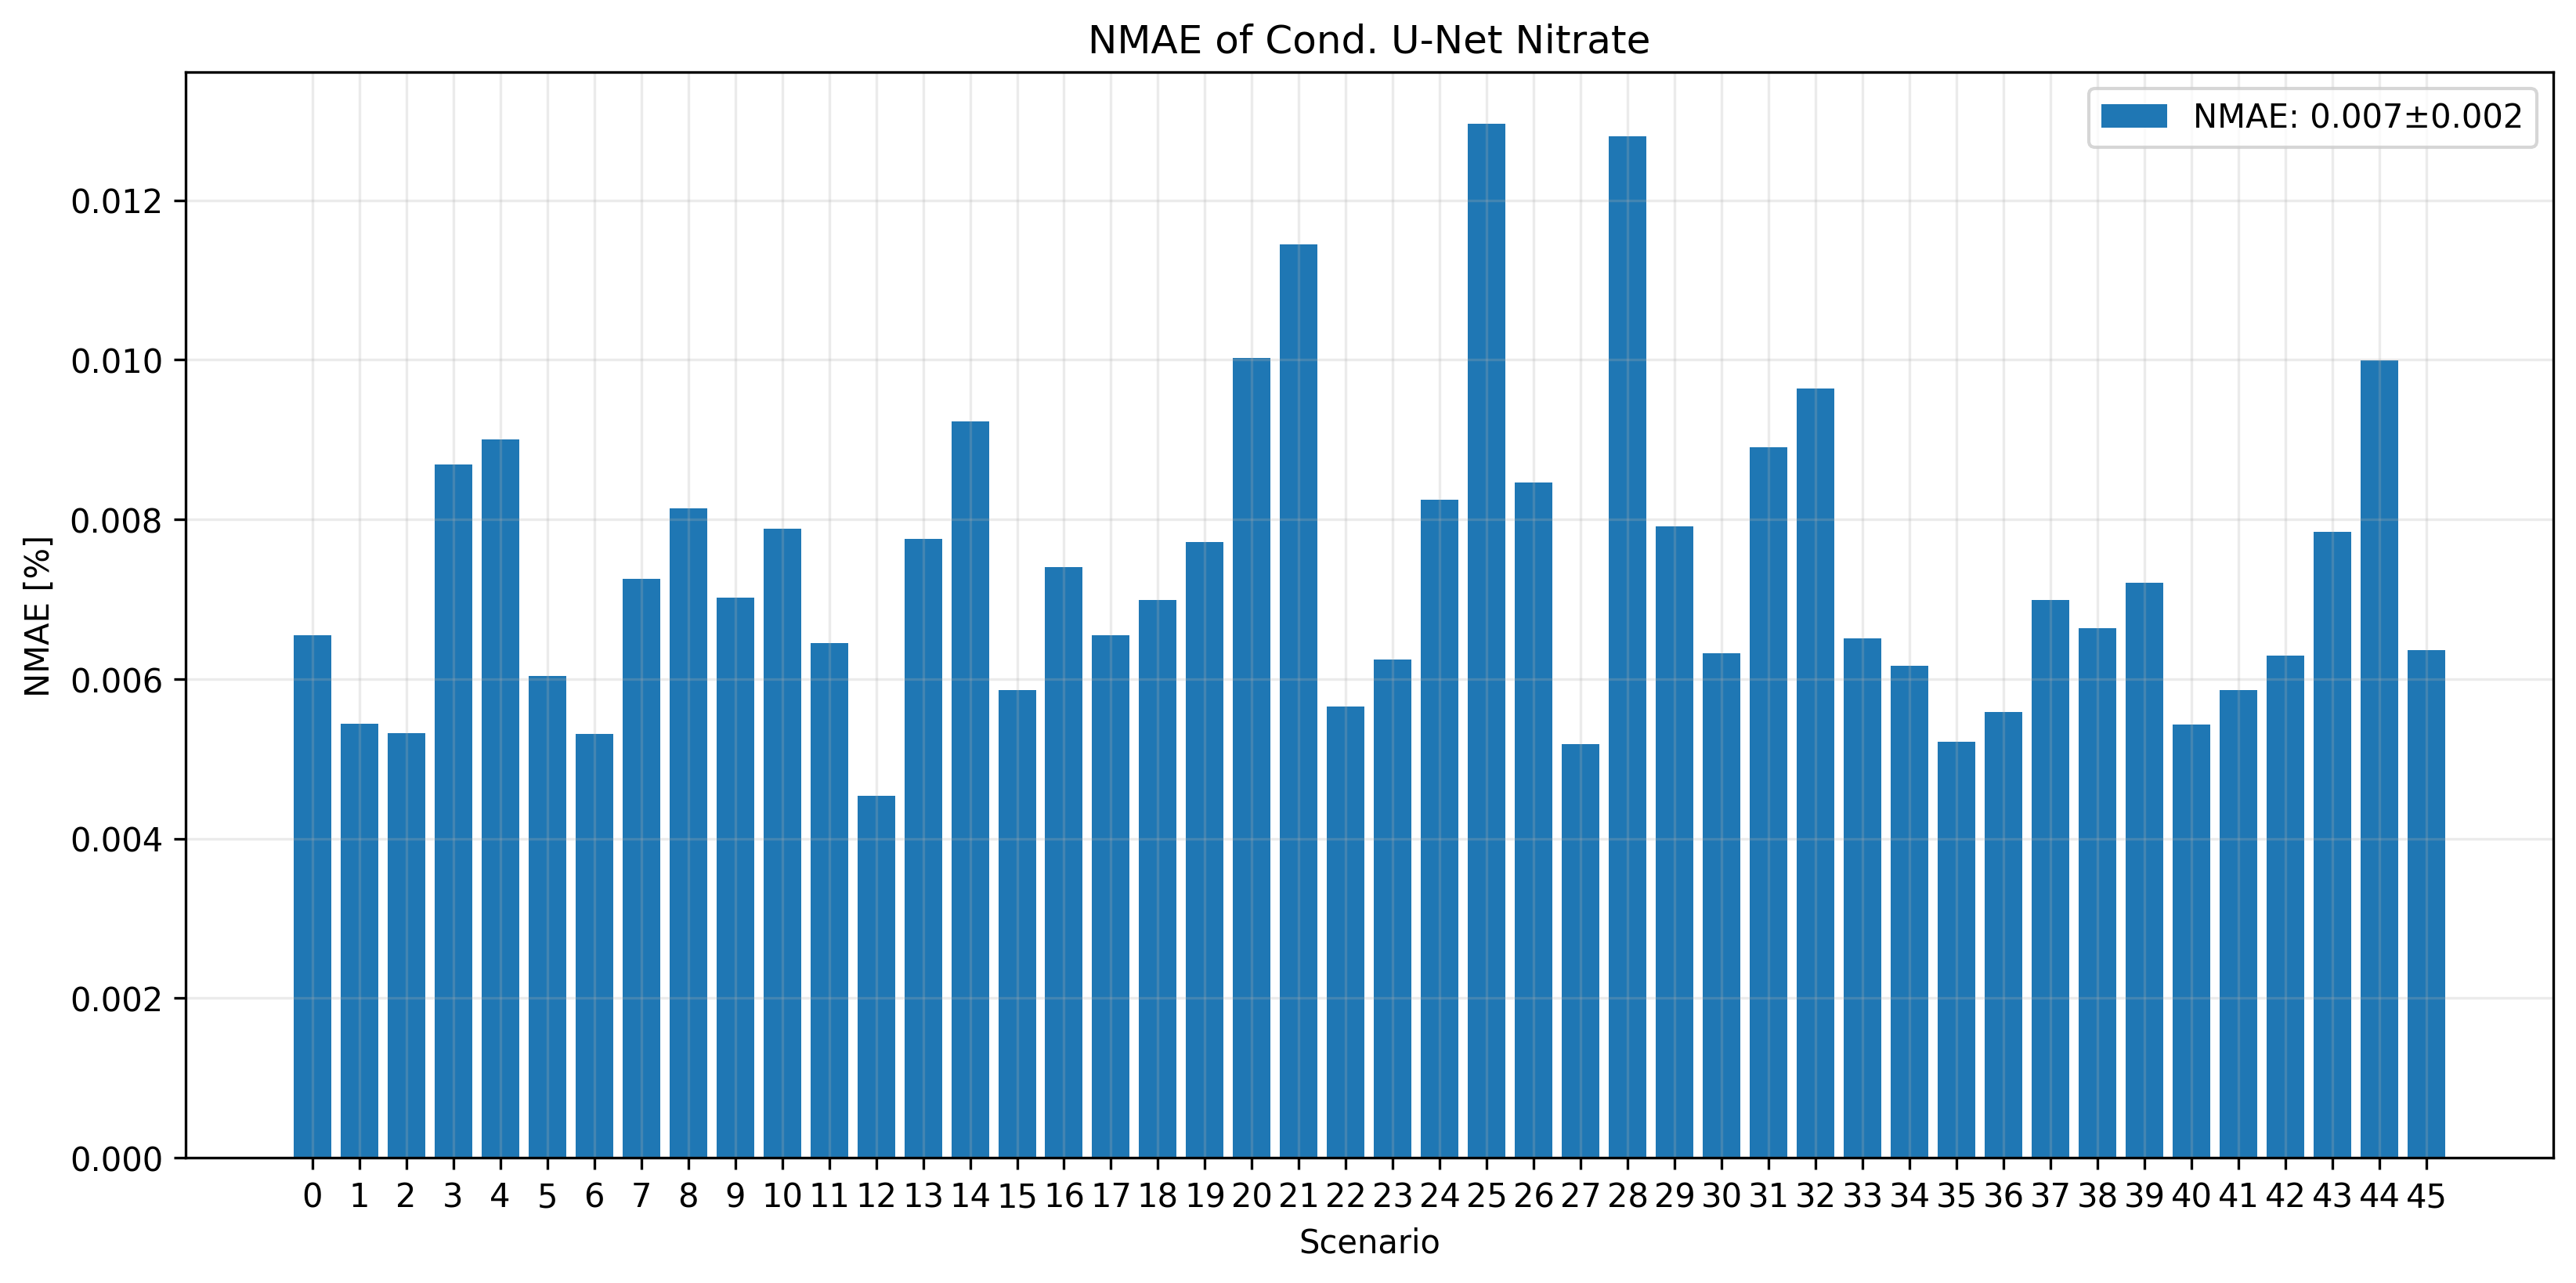

In [18]:
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]), score, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()

In [19]:
print(get_score((y_test[37].reshape(82,67)), y_pred[37]))

(array([0.00471858, 0.00562158, 0.00948591, 0.01276874, 0.01235848,
       0.0131091 , 0.01447556, 0.01523045, 0.01503894, 0.01506662,
       0.01477479, 0.0149714 , 0.01481642, 0.01270376, 0.01209136,
       0.01244032, 0.01205882, 0.01180714, 0.01050066, 0.01015079,
       0.00925413, 0.00994814, 0.00908142, 0.00931532, 0.0115637 ,
       0.01072055, 0.01067793, 0.01206065, 0.01175791, 0.01165115,
       0.01064734, 0.01254993, 0.01143621, 0.00996509, 0.00943549,
       0.00906115, 0.00902047, 0.00759608, 0.00669226, 0.00540695,
       0.00605303, 0.0061707 , 0.00546088, 0.00557579, 0.0055942 ,
       0.00634174, 0.00593331, 0.00652184, 0.00561798, 0.00497921,
       0.00554502, 0.00544247, 0.00441016, 0.00571297, 0.00546143,
       0.00580176, 0.00571635, 0.00632184, 0.00630417, 0.00728475,
       0.00786287, 0.00745693, 0.00812084, 0.00809757, 0.00815697,
       0.01025439, 0.00914299, 0.00854918, 0.00816941, 0.0073057 ,
       0.00766894, 0.00789281, 0.00941441, 0.00772377, 0.0074

[0]


/tmp/ipykernel_3759343/815748241.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_3759343/815748241.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_3759343/815748241.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_3759343/815748241.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_3759343/815748241.py:67: UserWarning: set_ticklab

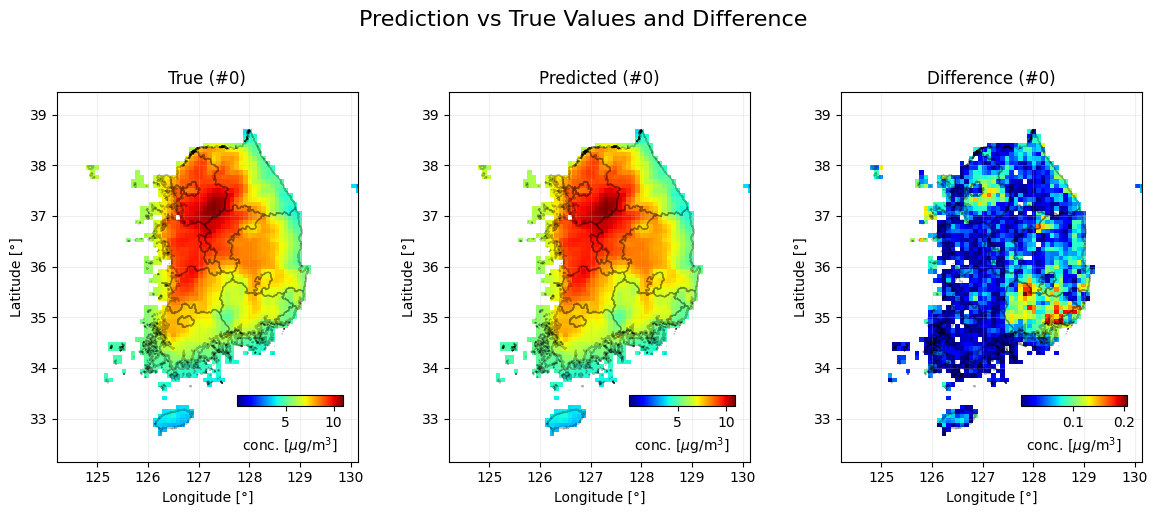

In [28]:
def plot_prediction_loss(y_true, y_pred, num_samples=1, indices=-1):
    if indices == -1 or indices < 0:
        indices = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        index = indices
        indices = []
        indices.append(index) 
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines, indices=0)

[37]


/tmp/ipykernel_3759343/4034451116.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_3759343/4034451116.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_3759343/4034451116.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_3759343/4034451116.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_3759343/4034451116.py:67: UserWarning: set_ti

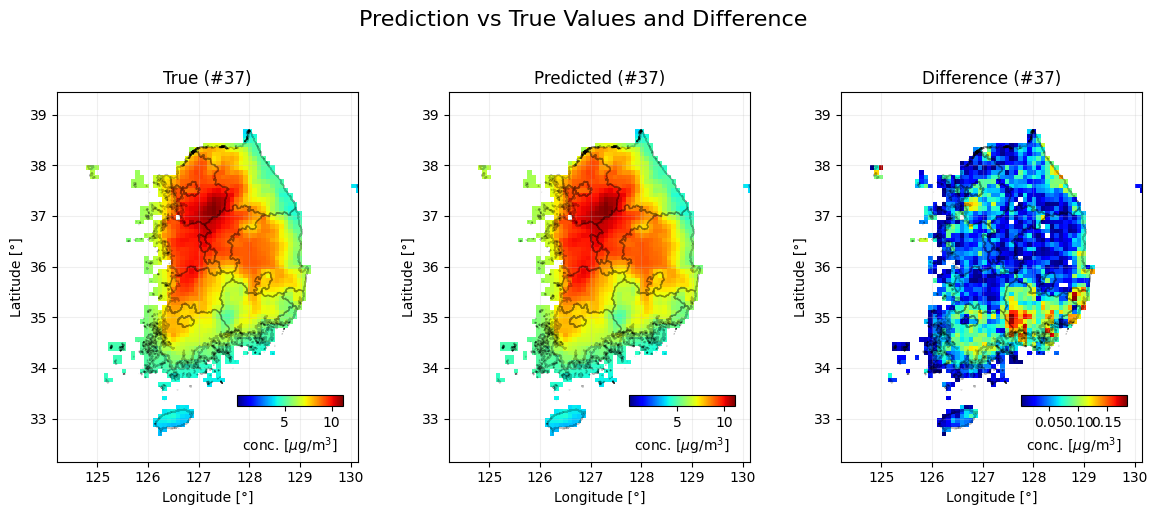

In [21]:
plot_prediction_loss(true_conc_map_w_lines, y_pred_restored, indices=37)

In [22]:
difference = np.abs(true_conc_map_w_lines[29] - pred_conc_map_w_lines[29])
new_diff = difference

/tmp/ipykernel_3759343/2595177862.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_3759343/2595177862.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_yticklabels([f"{i}" for i in range(32, 40, 1)])


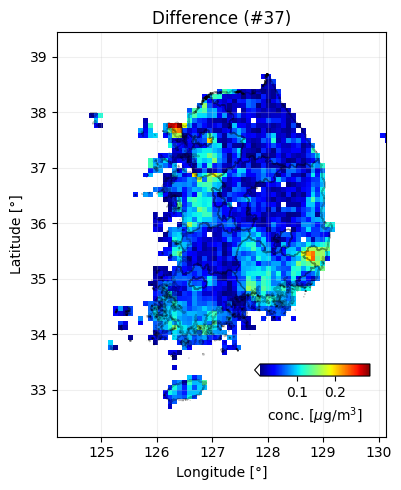

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
axes.imshow(
    new_diff[::-1], 
    cmap=cmap_white,
    vmin=0.001,
    extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
    interpolation='none')
axes = ctprvn_proj.boundary.plot(ax=axes, edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
axes.set_xlim(-180000, 414000)
axes.set_ylim(-585000, 144000)
axes.set_xlabel('Longitude [°]')
axes.set_ylabel('Latitude [°]')
axes.set_title(f"Difference (#{37})")
axes.grid(alpha=0.25, color='silver')
axes.set_xticklabels([f"{i}" for i in range(124, 132, 1)])
axes.set_yticklabels([f"{i}" for i in range(32, 40, 1)])
cbaxes = axes.inset_axes([0.6, 0.15, 0.35, 0.03])
cb = plt.colorbar(axes.images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)', extend='min')
cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')   
plt.tight_layout(rect=[0, 0, 1, 1])
plt.subplots_adjust(wspace=-0.4, hspace=0.2)
plt.show()